# Coding asssigment 1 John Salerno

# Packages and libraries

In [1]:
import os
import numpy as np
from PIL import Image
from skimage import io, color, img_as_ubyte, filters, exposure, feature, transform
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import euclidean_distances, manhattan_distances, cosine_distances
import xml.etree.ElementTree as ET
from skimage.filters import sobel

# Working Diretories
If you are running this locally, you will need to set your annotations folders and image folders in arrays below. These are set to my local wokring directory, feel free to change. Please note, any new directories that are generated due to cropting or modifications will be stored dynamically



In [2]:
annotation_paths = [
    '/Users/jsalerno/Code_Bases/school_repository/Anotations_John/n02088364-beagle',
    '/Users/jsalerno/Code_Bases/school_repository/Anotations_John/n02099601-golden_retriever',
    '/Users/jsalerno/Code_Bases/school_repository/Anotations_John/n02111500-Great_Pyrenees',
    '/Users/jsalerno/Code_Bases/school_repository/Anotations_John/n02115913-dhole'
]
image_folders = [
    '/Users/jsalerno/Code_Bases/school_repository/Images_john/n02088364-beagle',
    '/Users/jsalerno/Code_Bases/school_repository/Images_john/n02099601-golden_retriever',
    '/Users/jsalerno/Code_Bases/school_repository/Images_john/n02111500-Great_Pyrenees',
    '/Users/jsalerno/Code_Bases/school_repository/Images_john/n02115913-dhole'
]

# Helper Functions
this section in the notebook contains helper functions to deal with file pathing, image conversions, and other misolanious things that need to be done prior to analysis

In [3]:
#this helper will change files in the anotations folder into .xml files, Macs download these files as .dox
#so this is needed
def add_xml_extension_to_directories(directories):
    for directory in directories:
        print("{directory}")
        for filename in os.listdir(directory):
            # Construct the full file path
            old_file = os.path.join(directory, filename)
            
            if os.path.isfile(old_file):
                new_file = f"{old_file}.xml"
                
                # Rename file
                os.rename(old_file, new_file)
                print(f"{filename} -> {new_file}")

# this will verify image sizing for Q1                
def verify_image_sizes(image_folders, expected_size=(128, 128)):
    for folder in image_folders:
        for image_filename in os.listdir(folder):
            if not image_filename.endswith(('.jpg', '.png')):
                continue
            
            image_path = os.path.join(folder, image_filename)
            with Image.open(image_path) as img:
                if img.size != expected_size:
                    print(f"Image {image_filename} in {folder} has size {img.size}, expected {expected_size}.")

                    
                    
##### Please note i know these functions are not effiecient, for assigment 2 i will come back and refeactor them####                   
#returns first image path
def get_first_image_path(folder):
    for file_name in sorted(os.listdir(folder)):
        if file_name.lower().endswith(('.png', '.jpg', '.jpeg')):
            return os.path.join(folder, file_name)
    return None 

# returns 1st image for each call
def get_first_image_paths(grayscale_folders):
    first_image_paths = []
    for folder in grayscale_folders:
        for file in sorted(os.listdir(folder)):
            if file.lower().endswith(('.jpg', '.jpeg', '.png')):
                first_image_paths.append(os.path.join(folder, file))
                break  
    return first_image_paths

#will return awr number of images
def get_image_paths_from_folders(folders, num_images=2):
    image_paths = []
    for folder in folders:
        collected_images = 0
        for image_filename in sorted(os.listdir(folder)):
            if not image_filename.lower().endswith(('.jpg', '.png', '.jpeg')):
                continue
            if collected_images >= num_images:
                break
            image_paths.append(os.path.join(folder, image_filename))
            collected_images += 1
    return image_paths

# will return all images
def get_all_image_paths(folder):
    return [os.path.join(folder, f) for f in sorted(os.listdir(folder))
            if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

#gets paths for specific dogs
def get_image_paths_for_grey_beag(grayscale_folder, num_images):
    image_files = [f for f in sorted(os.listdir(grayscale_folder)) if f.endswith(('.jpg', '.jpeg', '.png'))]
    return [os.path.join(grayscale_folder, f) for f in image_files[:num_images]]

In [21]:
### only need to run if you dont have them saved as XMLs ###
#add_xml_extension_to_directories(annotation_paths)

# Resizing/Bounding/Image Manuplulation

In [5]:
# this function will extract bounding box information, please note this was based on the code snipet provided 
# in the class
def extract_bounding_boxes(folder_paths):
    bounding_boxes = {}
    for folder_path in folder_paths:
        for filename in os.listdir(folder_path):
            if not filename.endswith('.xml'):
                continue

            file_path = os.path.join(folder_path, filename)
            tree = ET.parse(file_path)
            root = tree.getroot()

            boxes = []
            for obj in root.iter('object'):
                bndbox = obj.find('bndbox')
                box = {
                    'xmin': int(bndbox.find('xmin').text),
                    'ymin': int(bndbox.find('ymin').text),
                    'xmax': int(bndbox.find('xmax').text),
                    'ymax': int(bndbox.find('ymax').text)
                }
                boxes.append(box)

            bounding_boxes[filename] = boxes

    return bounding_boxes

### This function is used to resize images to 128x128
def crop_and_resize_images(image_folders, bounding_boxes, output_size=(128, 128)):
    cropped_folders = []
    for image_folder in image_folders:
        output_folder = image_folder + '_cropped_resized'
        os.makedirs(output_folder, exist_ok=True)

        for image_filename in os.listdir(image_folder):
            if not image_filename.endswith(('.jpg', '.png')):
                continue

            image_path = os.path.join(image_folder, image_filename)
            image = Image.open(image_path)
            xml_filename = image_filename.replace('.jpg', '.xml').replace('.png', '.xml')
            
            if xml_filename in bounding_boxes:
                for box in bounding_boxes[xml_filename]:
                    # Crop the image
                    cropped_image = image.crop((box['xmin'], box['ymin'], box['xmax'], box['ymax']))
                    resized_image = cropped_image.resize(output_size)
                    output_path = os.path.join(output_folder, image_filename)
                    resized_image.save(output_path)
        cropped_folders.append(output_folder)
    return cropped_folders

## this will be used to convert images to grey_scale
def select_and_convert_to_grayscale(image_folders, num_images=2):
    outputs = []
    for folder in image_folders:
        images_processed = 0
        output_folder = f"{folder}_grayscale"
        os.makedirs(output_folder, exist_ok=True)

        for image_filename in os.listdir(folder):
            #had to pull the below endswtih from stackoverflow, was having an issue image proccessing
            if not image_filename.lower().endswith(('.jpg', '.png', '.jpeg')):
                continue

            if images_processed >= num_images:
                break

            image_path = os.path.join(folder, image_filename)
            image = io.imread(image_path)
            image_gray = color.rgb2gray(image)
            image_gray_ubyte = img_as_ubyte(image_gray)  
            output_path = os.path.join(output_folder, image_filename)
            io.imsave(output_path, image_gray_ubyte) 
            images_processed += 1
            
        print(f"Processed {num_images} images from {folder}")
        outputs.append(output_folder)
    return outputs




# Image analysis

In [6]:
def plot_images_and_freq_histograms(image_paths):
    fig, axes = plt.subplots(len(image_paths), 2, figsize=(10, 5 * len(image_paths)))
    
    if len(image_paths) == 1:
        axes = np.array([[axes]])
    
    for i, image_path in enumerate(image_paths):
        image = io.imread(image_path)
        #image
        ax_image = axes[i, 0]
        ax_image.imshow(image, cmap='gray')
        ax_image.axis('off')  
        ax_image.set_title(f"Image: {i+1}")
        #histogram
        ax_hist = axes[i, 1]
        histogram, bin_edges = np.histogram(image, bins=256, range=(0, 255))
        ax_hist.plot(bin_edges[0:-1], histogram)  
        ax_hist.set_title(f"Histogram: {i+1}")
        ax_hist.set_xlim([0, 255])  
        
    plt.tight_layout()
    plt.show()
    
# had to heavly rely on information provided by article for this part of remaining methods. 
def plot_images_with_edges(image_paths):
    fig, axes = plt.subplots(len(image_paths), 2, figsize=(10, 5 * len(image_paths)))
    if len(image_paths) == 1:
        axes = np.array([[axes]])

    for i, image_path in enumerate(image_paths):
        image = io.imread(image_path)
        edges = sobel(image)
        
        ax_image = axes[i, 0]
        ax_image.imshow(image, cmap='gray')
        ax_image.axis('off')  
        ax_image.set_title(f"Original Image: {i+1}")
        
        ax_edges = axes[i, 1]
        ax_edges.imshow(edges, cmap='gray')
        ax_edges.axis('off')
        ax_edges.set_title(f"Edges: {i+1}")   
    plt.tight_layout()
    plt.show()

def plot_edge_images(image_paths):
    images_per_row = 4
    nrows = len(image_paths) // images_per_row + (len(image_paths) % images_per_row > 0)
    fig, axes = plt.subplots(nrows=nrows, ncols=images_per_row, figsize=(20, 5 * nrows))
    axes = axes.ravel()  
    for ax in axes[len(image_paths):]:  
        ax.axis('off')
    for i, image_path in enumerate(image_paths):
        image = io.imread(image_path)
        edges = filters.sobel(image)        
        axes[i].imshow(edges, cmap='gray')
        axes[i].axis('off')
        axes[i].set_title(f"Edges: {i+1}")
    plt.tight_layout()
    plt.show()
    
def angle(dx, dy):
    return np.mod(np.arctan2(dy, dx), np.pi)

def process_and_plot_images_w_hist_bins(image_paths):
    fig, axes = plt.subplots(len(image_paths), 2, figsize=(10, 5 * len(image_paths)))

    for i, image_path in enumerate(image_paths):
        image = io.imread(image_path)
        if image.ndim == 3:
            image_gray = color.rgb2gray(image)
        else:
            image_gray = image

        dx = filters.sobel_h(image_gray)
        dy = filters.sobel_v(image_gray)
        angle_sobel = angle(dx, dy)

        hist, hist_centers = exposure.histogram(angle_sobel, nbins=36)

        ax_img = axes[i, 0]
        ax_img.imshow(image_gray, cmap='gray')
        ax_img.axis('off')
        ax_img.set_title(f"Grayscale Image: {i+1}")

        ax_hist = axes[i, 1]
        ax_hist.bar(hist_centers, hist, width=np.pi/18)
        ax_hist.set_xlabel("Bins")
        ax_hist.set_ylabel("Pixel Count")
        ax_hist.set_title(f"Edge Histogram: {i+1}")
    plt.tight_layout()
    plt.show()
    
    
### again redudant methods here, will come back and refactor at later point. 
def compute_edge_histogram(image_path, nbins=36, normalize=False, use_gradient_angles=True):
    image = io.imread(image_path)
    if image.ndim == 3:
        image = color.rgb2gray(image)
    if use_gradient_angles:
        dx = filters.sobel_h(image)
        dy = filters.sobel_v(image)
        gradient_angles = np.mod(np.arctan2(dy, dx), np.pi)
        hist, _ = exposure.histogram(gradient_angles, nbins=nbins)
    else:
        edges = filters.sobel(image)
        hist, _ = np.histogram(edges, bins=nbins, range=(0, 1))
        if normalize:
            hist = hist / hist.sum()
    return hist

# Question 2

In [7]:
#####QUESTION 2 PART A ##############

In [14]:
bounding_boxes = extract_bounding_boxes(annotation_paths)
cropped_resized_folders = crop_and_resize_images(image_folders, bounding_boxes)
### if any images are not 128x128, this verify function will return them here
verify_image_sizes(cropped_resized_folders)

Processed 2 images from /Users/jsalerno/Code_Bases/school_repository/Images_john/n02088364-beagle_cropped_resized
Processed 2 images from /Users/jsalerno/Code_Bases/school_repository/Images_john/n02099601-golden_retriever_cropped_resized
Processed 2 images from /Users/jsalerno/Code_Bases/school_repository/Images_john/n02111500-Great_Pyrenees_cropped_resized
Processed 2 images from /Users/jsalerno/Code_Bases/school_repository/Images_john/n02115913-dhole_cropped_resized


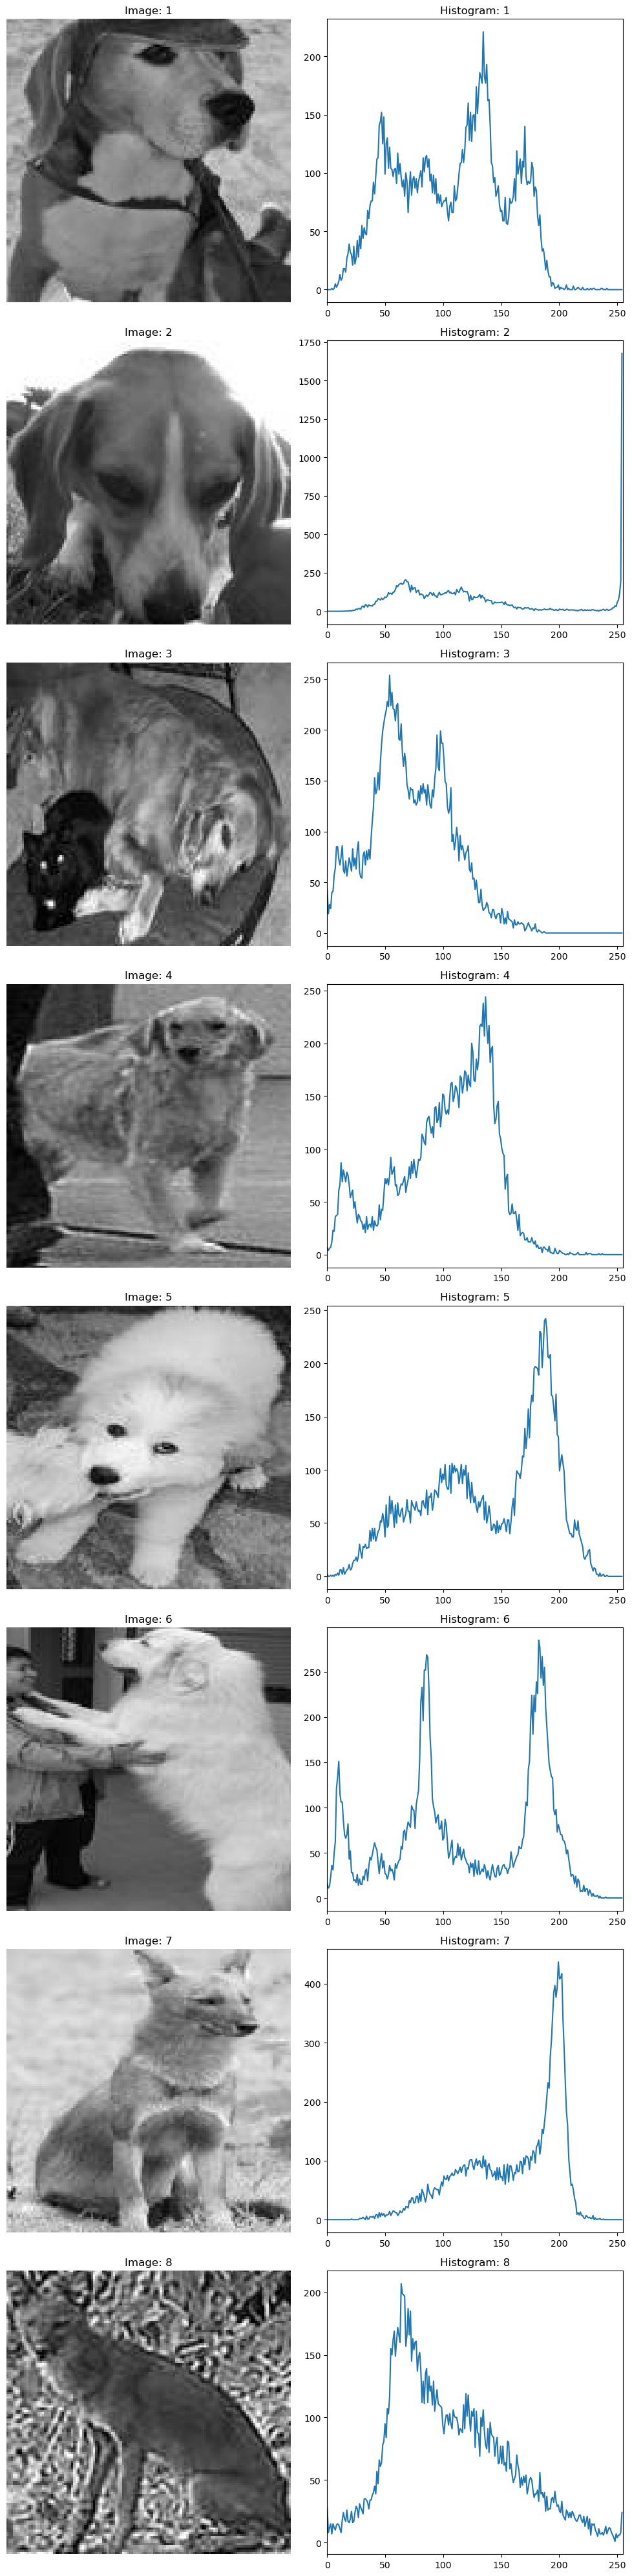

In [15]:
#####QUESTION 2 PART B ##############
#convert to greyscale
images_grey_scale = select_and_convert_to_grayscale(cropped_resized_folders)

#select_two_images
image_paths = get_image_paths_from_folders(images_grey_scale, num_images=2)

#plot 8 grayscale images
plot_images_and_freq_histograms(image_paths)

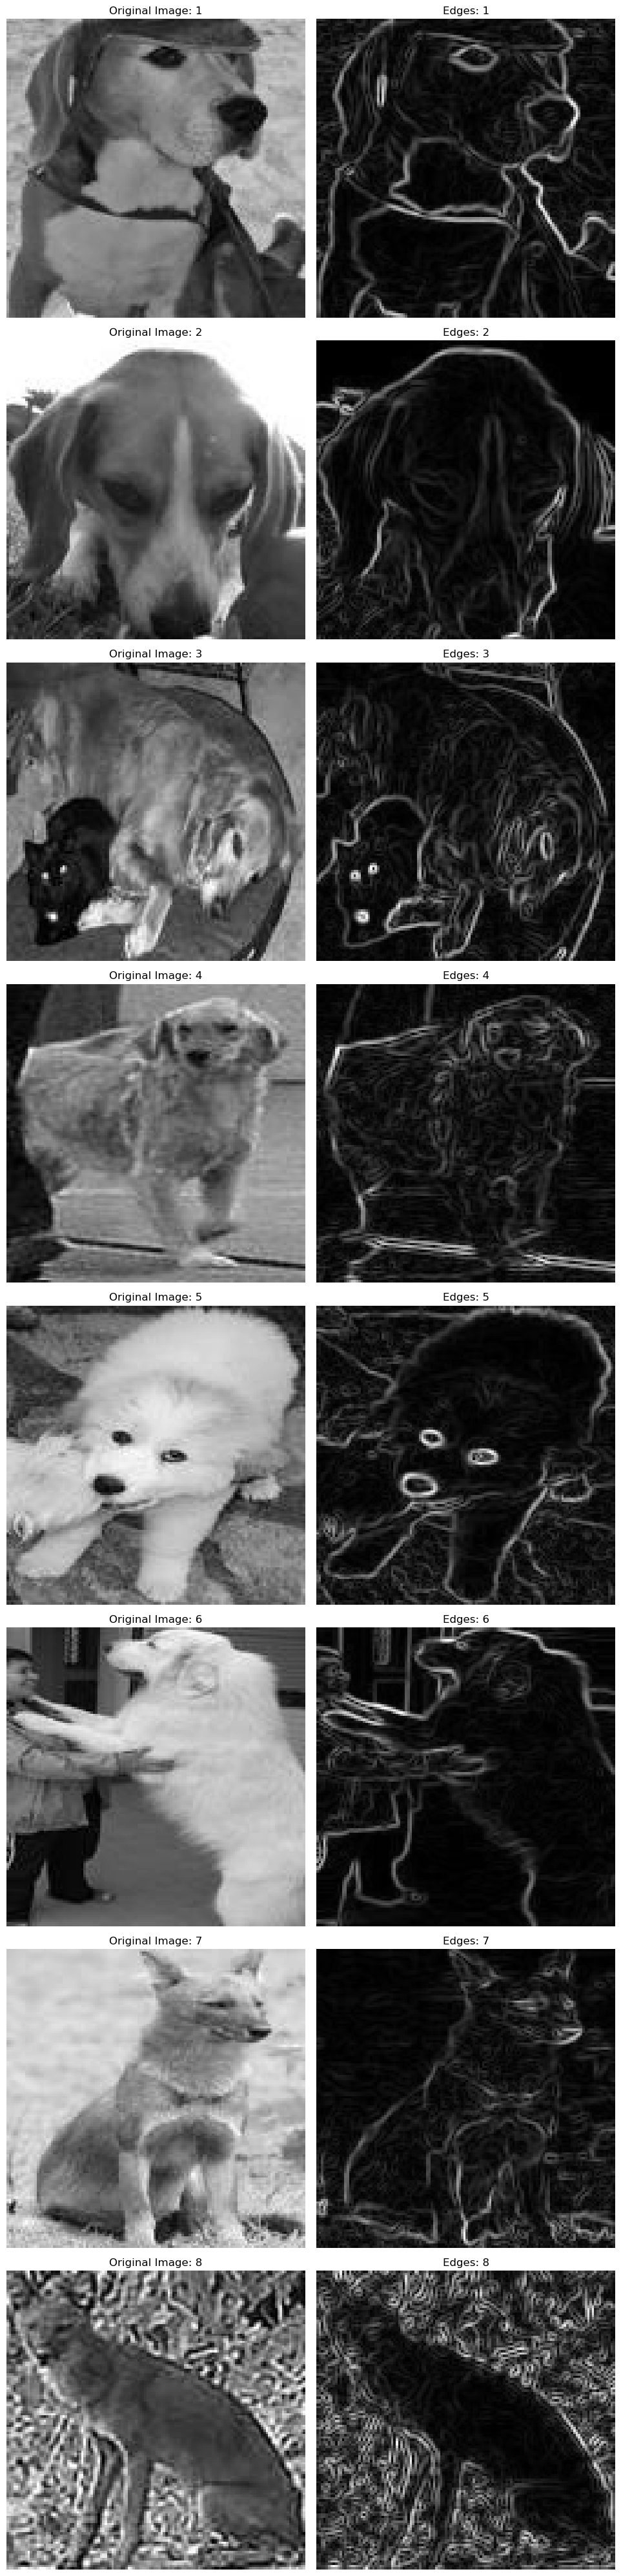

In [16]:
#plot 8 images with edgeing
plot_images_with_edges(image_paths)

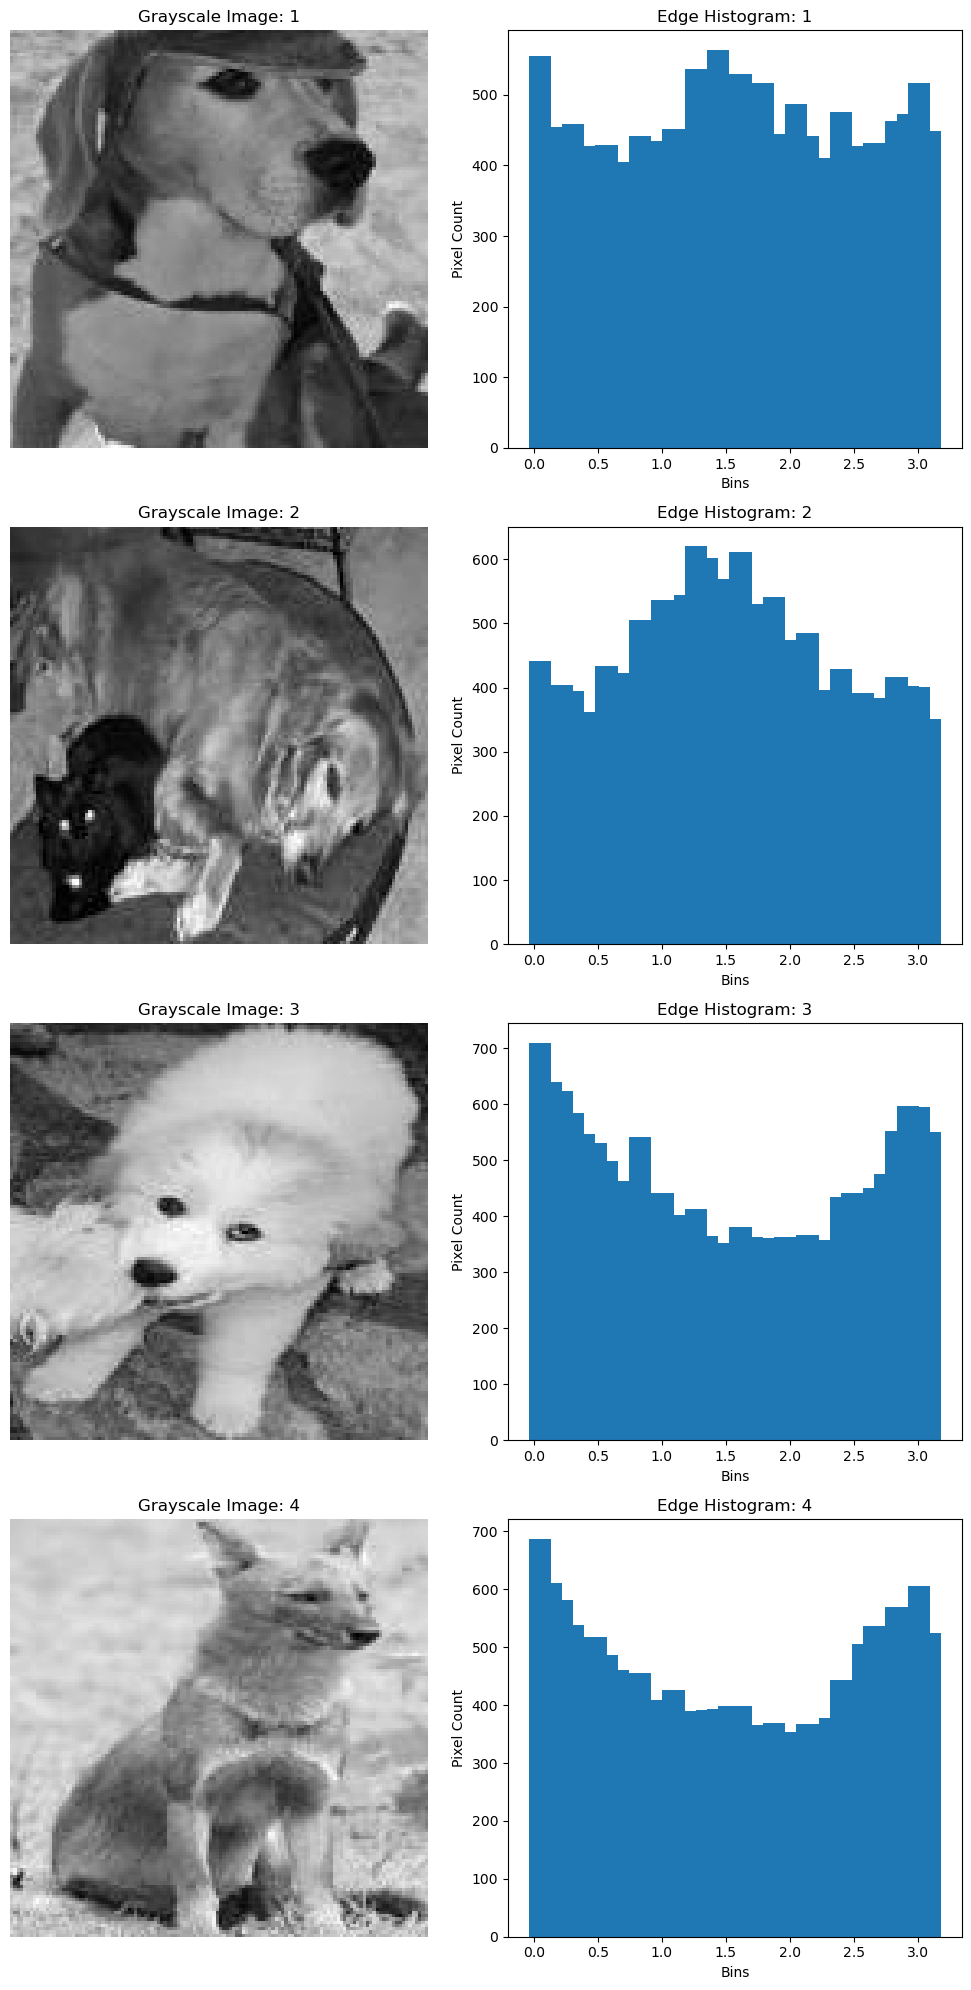

In [17]:
#####QUESTION 2 PART C ##############
image_paths = get_first_image_paths(images_grey_scale)
process_and_plot_images_w_hist_bins(image_paths)

In [18]:
#####QUESTION 2 PART D ##############
beagle_grayscale_folder = images_grey_scale[0]
golden_retriever_grayscale_folder = images_grey_scale[1]
# Get the first two images 
beagle_images = get_image_paths_for_grey_beag(beagle_grayscale_folder, 2)
golden_retriever_image = get_image_paths_for_grey_beag(golden_retriever_grayscale_folder, 1)
# Combine the paths
selected_image_paths = beagle_images + golden_retriever_image
edge_histograms = [compute_edge_histogram(path) for path in selected_image_paths]

#(same class)
euclidean_dist_same_class = euclidean_distances([edge_histograms[0]], [edge_histograms[1]])[0][0]
manhattan_dist_same_class = manhattan_distances([edge_histograms[0]], [edge_histograms[1]])[0][0]
cosine_dist_same_class = cosine_distances([edge_histograms[0]], [edge_histograms[1]])[0][0]

# different classes
euclidean_dist_diff_class = euclidean_distances([edge_histograms[0]], [edge_histograms[2]])[0][0]
manhattan_dist_diff_class = manhattan_distances([edge_histograms[0]], [edge_histograms[2]])[0][0]
cosine_dist_diff_class = cosine_distances([edge_histograms[0]], [edge_histograms[2]])[0][0]

print("Same Class")
print(f"Euclidean: {euclidean_dist_same_class}")
print(f"Manhattan: {manhattan_dist_same_class}")
print(f"Cosine: {cosine_dist_same_class}")

print("\nDifferent Class")
print(f"Euclidean : {euclidean_dist_diff_class}")
print(f"Manhattan : {manhattan_dist_diff_class}")
print(f"Cosine : {cosine_dist_diff_class}")

Same Class
Euclidean: 1421.3796115042596
Manhattan: 3920.0
Cosine: 0.10777065636225103

Different Class
Euclidean : 376.6669616518019
Manhattan : 1882.0
Cosine : 0.009292707201864925


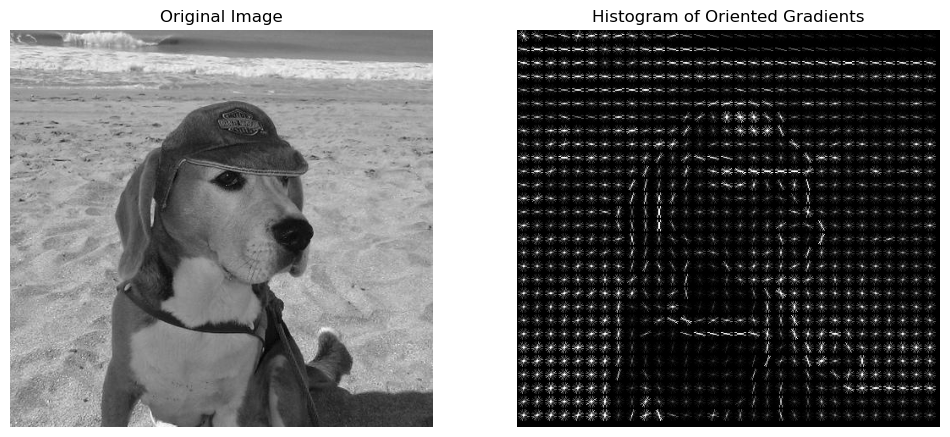

In [19]:
#####QUESTION 2 PART E ##############

# Example usage with the Beagle grayscale folder. had to hard code due to pathing issue on machine
beagle_grayscale_folder = '/Users/jsalerno/Code_Bases/school_repository/Images_john/n02088364-beagle_grayscale'
image_path = get_first_image_path(beagle_grayscale_folder)
image = io.imread(image_path)
# Compute HOG 
fd, hog_image = feature.hog(image, orientations=8, pixels_per_cell=(16, 16),
                            cells_per_block=(1, 1), visualize=True)
# Rescale
hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))
# Visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), sharex=True, sharey=True)
ax1.axis('off')
ax1.imshow(image, cmap=plt.cm.gray)
ax1.set_title('Original Image')
ax2.axis('off')
ax2.imshow(hog_image_rescaled, cmap=plt.cm.gray)
ax2.set_title('Histogram of Oriented Gradients')
plt.show()

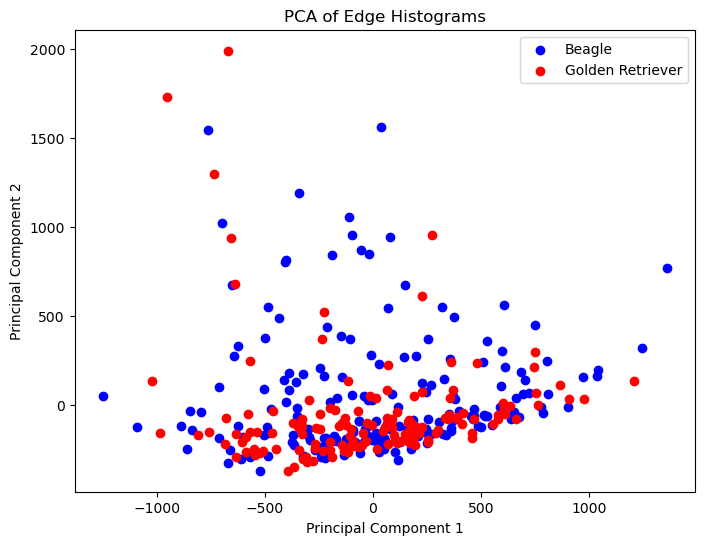

In [20]:
#####QUESTION 2 PART E ##############
beagle_folder = '/Users/jsalerno/Code_Bases/school_repository/Images_john/n02088364-beagle_cropped_resized'
golden_retriever_folder = '/Users/jsalerno/Code_Bases/school_repository/Images_john/n02099601-golden_retriever_cropped_resized'
beagle_images = get_all_image_paths(beagle_folder)
golden_retriever_images = get_all_image_paths(golden_retriever_folder)

# Compute edge histograms 
histograms = [compute_edge_histogram(img_path) for img_path in beagle_images + golden_retriever_images]
histograms_np = np.array(histograms)

# Perform PCA
pca = PCA(n_components=2)
histograms_pca = pca.fit_transform(histograms_np)
len_beagle = len(beagle_images)
len_golden_retriever = len(golden_retriever_images)
plt.figure(figsize=(8, 6))
plt.scatter(histograms_pca[:len_beagle, 0], histograms_pca[:len_beagle, 1], c='blue', label='Beagle')
plt.scatter(histograms_pca[len_beagle:len_beagle + len_golden_retriever, 0], histograms_pca[len_beagle:len_beagle + len_golden_retriever, 1], c='red', label='Golden Retriever')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.title('PCA of Edge Histograms')
plt.show()